# Particle Swarm Optimization

In this section, Particle Swarm Optimization (PSO) algorithm is demonstrated. PSO is a population-based stochastic optimization algorithm inspired by social behavior. The algorithm was originally proposed by Kennedy and Eberhart in 1995. The algorithm is based on a population of particles that move around in search space and update their position and velocity based on locally and globally best-found solutions, refer lecture notes for more details.

> **_NOTE:_** You need to install [pymoo](https://pymoo.org/index.html) which provides single- and multi-objective global optimization algorithms. Activate the environment you created in anaconda prompt and install pymoo using `pip install pymoo`.

[Jones function](intro:jones-function) will be used to demonstrate the method. Following block imports all required packages:

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.optimize import minimize
from pymoo.config import Config
Config.warnings['not_compiled'] = False

Defining problem and performing optimization is sightly different from previous sections. Typically, `pymoo` requries three components to perform optimization: `problem` (defines the objective function and constraints), `algorithm` (defines the optimization algorithm), and `minimize` is the function that performs optimization.

Below block defines the problem, it is recommended that you read pymoo's [problem](https://pymoo.org/problems/index.html) documentation to understand the arguments:

In [21]:
class JonesFunction(Problem):
    """
        Class for Jones function
    """

    def __init__(self):
        super().__init__(n_var=2, n_obj=1, n_constr=0, xl=np.array([-2, -2]), xu=np.array([4, 4]))

    def _evaluate(self, x, out, *args, **kwargs):

        x1 = x[:, 0]
        x2 = x[:, 1]

        out["F"] = x1**4 + x2**4 - 4*x1**3 - 3*x2**3 + 2*x1**2 + 2*x1*x2

problem = JonesFunction()

As you can see in previous code block, the `JonesProblem` is a class (not a function) which inherits from `Problem` class defined in `pymoo`. The class has two methods: `__init__` and `_evaluate`. The `__init__` method defines the problem settings, and `_evaluate` method outlines how to evaluate the objective function and constraints, if any. The `_evaluate` method is called by `pymoo` during optimization.

> **_NOTE:_** Bounds are an essential part of global optimization algorithms since entire design space within the bounds is searched. It is important that bounds are carefully selected. If the bounds are too large, the algorithm will take longer to converge. If the bounds are too small, the algorithm may not find global optimum. 

Below block defines the algorithm, it is recommended that you read pymoo's [PSO](https://pymoo.org/algorithms/soo/pso.html) documentation to understand the arguments:

In [22]:
pop_size = 10 * problem.n_var # Number of individuals in the population: 10 times number of variables
sampling = LHS() # How the initial population is sampled

algorithm = PSO(pop_size=pop_size, sampling=sampling)

In previous code block, `PSO` class is initialized with user provided settings for the algorithm, refer documentation to see what all can be defined. The `sampling` is set to LHS which stands for Latin Hypercube Sampling and is used to generate initial population within the bounds. LHS and other methods will be covered in Design of Experiments lecture.

Below block performs optimization using `minimize` function from `pymoo`, it is recommended that you read pymoo's [minimize](https://pymoo.org/interface/minimize.html) documentation to see the list of arguments that can be provided. A termination criteria is also provided which tells optimizer when to stop, refer pymoo's [termination](https://pymoo.org/interface/termination.html) documentation to see what all termination criteria can be provided.

> **_NOTE_**: The `seed` option has been set so that results can be compared to other algorithms. If you change the seed value or remove that option, then you will get different results.

In [23]:
termination = DefaultSingleObjectiveTermination(
    xtol=1e-3,
    cvtol=1e-3,
    ftol=1e-3,
    period=10,
    n_max_gen=1000,
    n_max_evals=100000
)

res = minimize(problem, algorithm, termination=termination, verbose=False, 
               save_history=True, seed=1)

print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))

Best solution found: 
X = [ 2.67344824 -0.67616884]
F = [-13.53203347]


PSO is able to get to the global optimum. You can change the termination criteria or PSO settings (such as inertia, cognitive or social impact) to see how the algorithm's performance changes. The `minimize` function also returns an object of `Result` class which contains all the information about optimization, refer pymoo's [result](https://pymoo.org/interface/result.html) documentation to see what all information is available.

Below block of code uses `res` variable to plot the variation of best, mean, and worst function value in the population over generations:

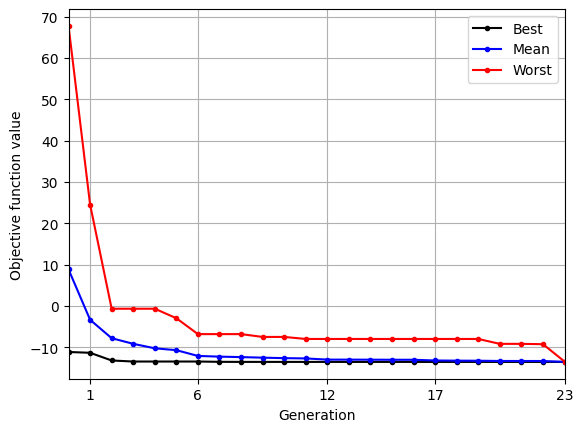

In [24]:
niter = len(res.history) # Number of iterations
iterations = np.linspace(0, niter-1, niter, dtype=np.int32) # Iteration vector
fbest = np.zeros(niter) # Vector to store the best fitness value at each iteration
fmean = np.zeros(niter) # Vector to store the mean fitness value at each iteration
fworst = np.zeros(niter) # Vector to store the worst fitness value at each iteration

for itr in iterations:
    f = res.history[itr].pop.get("F")
    fbest[itr] = np.min(f)
    fmean[itr] = np.mean(f)
    fworst[itr] = np.max(f)

# Plotting the convergence curve
fig, ax = plt.subplots()
ax.plot(iterations, fbest, "k", marker=".", label='Best')
ax.plot(iterations, fmean, "b", marker=".", label='Mean')
ax.plot(iterations, fworst, "r", marker=".", label='Worst')
ax.set_xlabel('Generation')
ax.set_ylabel('Objective function value')
ax.set_xlim(left=0, right=niter-1)
ax.set_xticks(np.linspace(1, niter-1, 5, dtype=np.int32))
ax.legend()
ax.grid()

As the population evolves, the best, mean, and worst function values in the population converge.

Below block of code defines a plotting function and uses `res` variable to visualize the location and velocity of particles as optimization progresses:

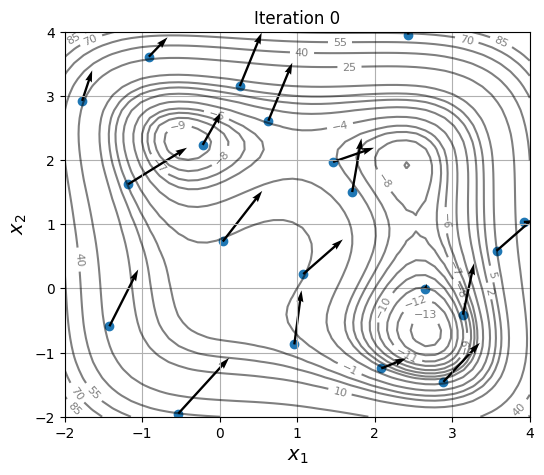

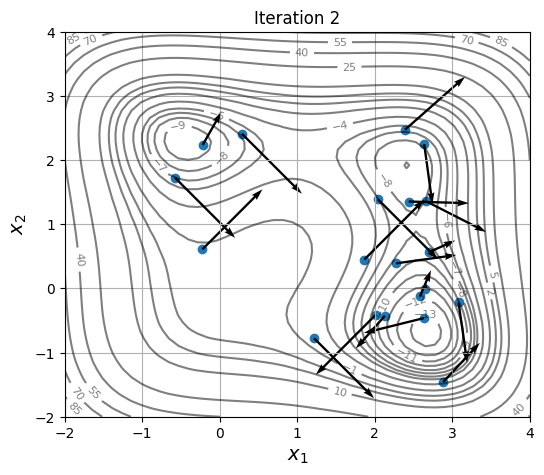

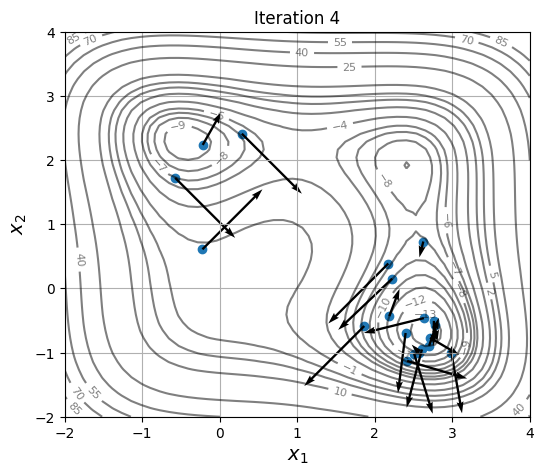

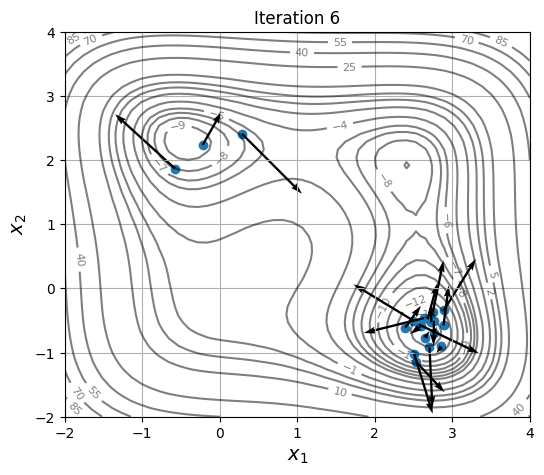

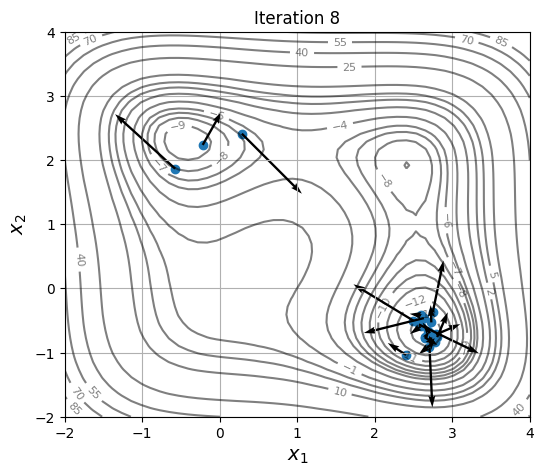

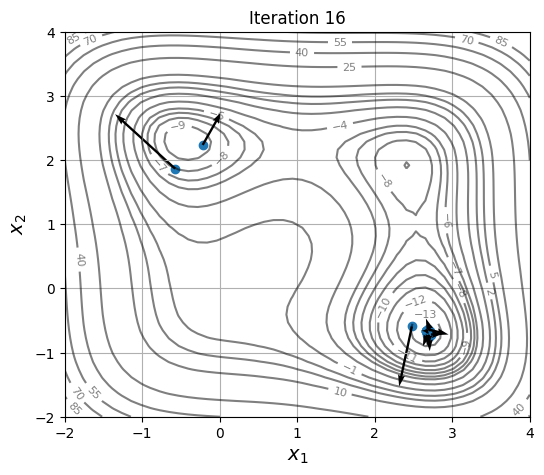

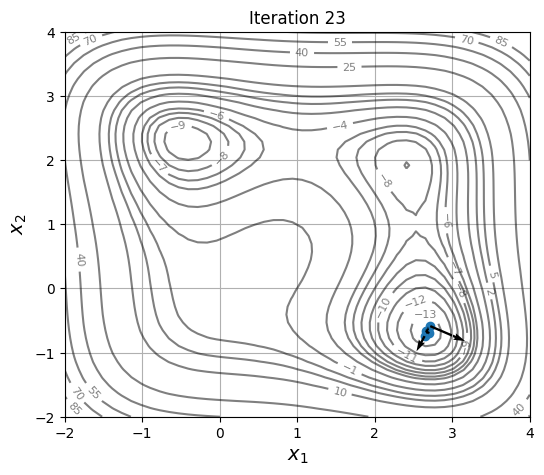

In [25]:
def plot_jones_function(ax=None):
    """
        Function which plots the jones function

        Input:
        ax (optional) - matplotlib axis object. If not provided, a new figure is created

        Returns ax object containing jones function plot
    """

    num_points = 50

    # Defining x and y values
    x = np.linspace(-2,4,num_points)
    y = np.linspace(-2,4,num_points)

    # Creating a mesh at which values will be evaluated and plotted
    X, Y = np.meshgrid(x, y)

    # Evaluating the function values at meshpoints
    out = {}
    Z = problem._evaluate(np.hstack((X.reshape(-1,1),Y.reshape(-1,1))), out)
    Z = out["F"].reshape(num_points,num_points)

    # Denoting at which level to add contour lines
    levels = np.arange(-13,-5,1)
    levels = np.concatenate((levels, np.arange(-4, 8, 3)))
    levels = np.concatenate((levels, np.arange(10, 100, 15)))

    # Plotting the contours
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))

    CS = ax.contour(X, Y, Z, levels=levels, colors="k", linestyles="solid", alpha=0.5)
    ax.clabel(CS, inline=1, fontsize=8)
    ax.set_xlabel("$x_1$", fontsize=14)
    ax.set_ylabel("$x_2$", fontsize=14)
    ax.set_title("Jones Function", fontsize=14)

    return ax

niter = len(res.history) # Number of iterations
iterations = np.linspace(0, 8, 5, dtype=np.int32) # Array of iterations
iterations = np.concatenate(( iterations, np.array([16, niter-1]) )) # Adding the last iteration

# Plotting the particle evolution
for itr in iterations:
    ax = plot_jones_function()
    ax.scatter(res.history[itr].pop.get("X")[:, 0], res.history[itr].pop.get("X")[:, 1])
    ax.quiver(res.history[itr].pop.get("X")[:, 0], res.history[itr].pop.get("X")[:, 1],
              res.history[itr].pop.get("V")[:, 0], res.history[itr].pop.get("V")[:, 1],
              scale=2.0, scale_units='inches', width=0.005)
    ax.set_title("Iteration %s" % itr)
    ax.grid()
    ax.set_xlim([-2, 4])
    ax.set_ylim([-2, 4])
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

As location and velocity of particles are updated, they move towards the global optimum.